In [20]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.pyplot import ion
from scipy.signal import convolve2d
import pandas as pd
import seaborn as sn
%matplotlib inline

This is a secret method that implements the heat distribution in a room.

Freezing Fritz, is a pretty cool guy. He has one problem, though. In his house, it is quite often too cold or to hot during the night. Then he has to get up and open or close his windows or turn on the heat. Needless to say, he would like to avoid this. 

However, his flat has three doors that he can keep open or closed, it has four radiators, and four windows. It seems like there are endless possibilities of prepping the flat for whatever temperature the night will have. 

Fritz, does not want to play his luck any longer and decided to get active. He recorded the temperature outside and inside of his bedroom for the last year. Now he would like to find an prediction that, given the outside temperature, as well as a certain configuration of his flat, tells him how cold or warm his bedroom will become.

Can you help Freezing Fritz to find blissful sleep?


Let us first look at the situation. In the lecture notes you will find the experiment that Fritz carried out described in 8 cases.

For the experiment, we first load the data

In [21]:
data_train_Temperature = pd.read_csv('data_train_Temperature.csv')
data_test_Temperature = pd.read_csv('data_test_Temperature.csv')
data_train_Temperature.head()

,Window 1,Window 2,Window 3,Window 4,Heat Control 1,Heat Control 2,Heat Control 3,Heat Control 4,Door 1,Door 2,Door 3,Temperature Outside,Temperature Bed
0,0.0,0.0,1.0,1.0,0.0,5.0,1.0,1.0,0.0,1.0,1.0,8.232086,17.077426
1,0.0,0.0,1.0,1.0,1.0,4.0,1.0,3.0,1.0,1.0,1.0,5.935949,16.413221
2,1.0,1.0,1.0,0.0,1.0,5.0,5.0,3.0,0.0,0.0,1.0,10.550271,23.228559
3,0.0,1.0,1.0,0.0,4.0,3.0,3.0,3.0,1.0,0.0,0.0,2.591696,16.224344
4,1.0,0.0,0.0,1.0,2.0,1.0,4.0,0.0,1.0,1.0,1.0,18.516631,21.047208


Let us look at this closely

In [22]:
data_train_Temperature.describe()

,Window 1,Window 2,Window 3,Window 4,Heat Control 1,Heat Control 2,Heat Control 3,Heat Control 4,Door 1,Door 2,Door 3,Temperature Outside,Temperature Bed
count,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000
mean,0.478082,0.473973,0.473973,0.502740,2.450685,2.561644,2.515068,2.416438,0.475342,0.471233,0.513699,8.211303,19.624089
std,0.499862,0.499664,0.499664,0.500335,1.735107,1.710825,1.734953,1.695391,0.499734,0.499514,0.500155,7.857266,3.915569
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-4.945738,9.246765
25%,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.377688,16.473373
50%,0.000000,0.000000,0.000000,1.000000,2.000000,3.000000,3.000000,2.000000,0.000000,0.000000,1.000000,7.660876,20.289835
75%,1.000000,1.000000,1.000000,1.000000,4.000000,4.000000,4.000000,4.000000,1.000000,1.000000,1.000000,15.096424,22.714459
max,1.000000,1.000000,1.000000,1.000000,5.000000,5.000000,5.000000,5.000000,1.000000,1.000000,1.000000,21.982949,28.306661


We use the correlation matrix again to see how each of the parameters of the problem affect the temperature in the bedroom. We also look at how the trade-off between outside and inside temperature is affected by some of the parameters.

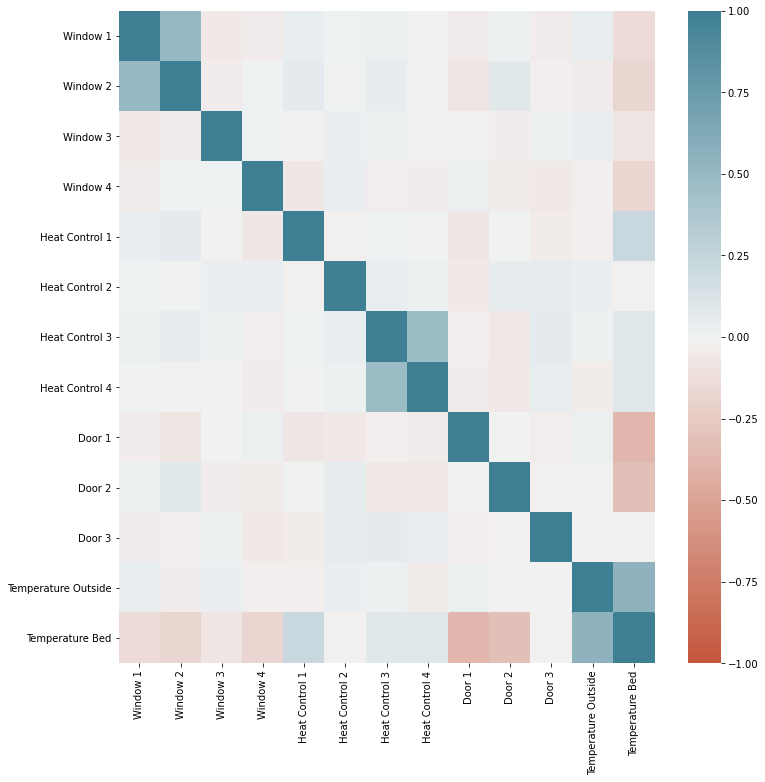

<Figure size 864x864 with 0 Axes>

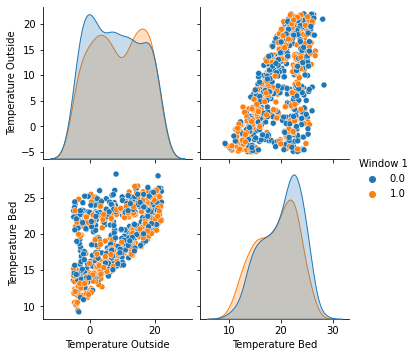

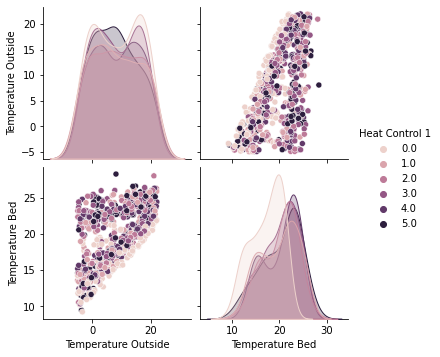

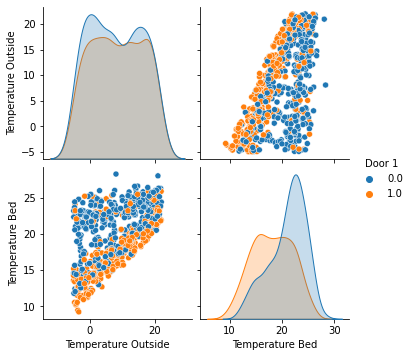

In [23]:
corrMatrix = data_train_Temperature.corr()
plt.figure(figsize = (12,12))
palette = sn.diverging_palette(20, 220, n=256)
sn.heatmap(corrMatrix, annot=False, cmap = palette, vmin = -1, vmax = 1)
plt.show()

plt.figure(figsize = (12,12))
sn.pairplot(data_train_Temperature, vars = ['Temperature Outside', 'Temperature Bed'], kind = 'scatter', hue='Window 1')
sn.pairplot(data_train_Temperature, vars = ['Temperature Outside', 'Temperature Bed'], kind = 'scatter', hue='Heat Control 1')
sn.pairplot(data_train_Temperature, vars = ['Temperature Outside', 'Temperature Bed'], kind = 'scatter', hue='Door 1')
plt.show()

We do not have that many data points. We should therefore first reduce the dimensionality of the problem.

My idea is to interpolate over the data but weigh it according to my observations. So I give low weights to windows 2 and 3. Same with door 3.
Then 

We predict on the first 80% of the data and then validate on the remaining 20%

In [24]:
observations = data_train_Temperature.shape[0]
simple_data_set = data_train_Temperature.copy().drop(range(int(0.2*observations)), axis = 0)

def predict(data):
    simple_test_set = data.copy()

    #some parameters are more important to fit right than others. (In our case, window 1 and doors 1 and 2)
    weights = np.ones(12)
    weights[0]  = 10 # Window 1
    weights[1]  = 1 # Window 2
    weights[2]  = 1 # Window 3
    weights[3]  = 10 # Window 4
    weights[4]  = 1 # Heat 1
    weights[5]  = 1 # Heat 2
    weights[6]  = 1 # Heat 3
    weights[7]  = 1 # Heat 4
    weights[8]  = 10 # Door 1
    weights[9]  = 10 # Door 2
    weights[10] = 1 # Door 3
    weights[11] = 1 # Temp Out 

    for k in range(simple_test_set.shape[0]):
        value = 0;
        totaldist = 0
        
        
        for j in range(simple_data_set.values.shape[0]):
            value = value + simple_data_set.values[j,-1]/(np.linalg.norm(weights*simple_data_set.values[j,:-1] - weights*simple_test_set.values[k,:-1]))**4
            totaldist = totaldist + 1/(np.linalg.norm(weights*simple_data_set.values[j,:-1] - weights*simple_test_set.values[k,:-1]))**4
        simple_test_set.values[k, -1] = value/totaldist
    
    
    return simple_test_set

Now we compute error on validation set:

In [25]:
validation_set = data_train_Temperature.copy().drop(range(int(0.2*observations), observations), axis = 0)
res = predict(validation_set)
# root mean square error:
np.linalg.norm(res.values[:,-1] - validation_set.values[:,-1])/np.sqrt(validation_set.shape[0])

2.0164742910099527

The algorithm, was not very sophisticated, nonetheless I came within an accuracy of 2 degrees. For me this seems acceptable. 
Maybe you can help Freezing Fritz even more?

I will just store my prediction on the test set now:

In [26]:
#make prediction 
prediction = predict(data_test_Temperature)
predicted_Temperatures = prediction.values[:,-1]
    
np.savetxt('PhilippPetersens_Temperature_prediction.csv', predicted_Temperatures, delimiter=',') 